In [1]:
import os
import time
import uuid
import cv2
import tensorflow as tf


Collecting images with OpenCv & annotating images with LabelMe

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30


In [3]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')#passes the image to path with unique ids
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.4)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [4]:
!labelme


In [5]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [6]:
#AVOIDING OOM ERRORS
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[]

In [7]:
tf.test.is_gpu_available()


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [8]:
images =tf.data.Dataset.list_files(r'C:\Users\ZEYNEP\OneDrive\Masaüstü\ITech-Data sci\.vscode\data\images\*.jpg',shuffle=False)

In [9]:
def load_image(x):
    byte_img=tf.io.read_file(x)
    img= tf.io.decode_jpeg(byte_img)
    return img

In [10]:
images = images.map(load_image)

In [11]:
images.as_numpy_iterator().next()

array([[[ 26,  26,  24],
        [ 26,  26,  24],
        [ 27,  28,  23],
        ...,
        [230, 229, 224],
        [221, 206, 199],
        [186, 163, 155]],

       [[ 26,  26,  24],
        [ 26,  26,  24],
        [ 27,  28,  23],
        ...,
        [220, 219, 214],
        [214, 195, 188],
        [176, 152, 142]],

       [[ 26,  26,  24],
        [ 26,  26,  24],
        [ 26,  26,  24],
        ...,
        [207, 202, 198],
        [201, 179, 168],
        [173, 144, 130]],

       ...,

       [[ 29,  30,  24],
        [ 29,  30,  24],
        [ 28,  30,  25],
        ...,
        [ 92,  93,  98],
        [ 92,  92, 100],
        [104, 104, 112]],

       [[ 29,  30,  24],
        [ 29,  30,  24],
        [ 27,  29,  24],
        ...,
        [ 94,  93,  99],
        [ 92,  91,  99],
        [105, 103, 114]],

       [[ 27,  28,  22],
        [ 28,  29,  23],
        [ 27,  29,  24],
        ...,
        [ 95,  94, 100],
        [ 93,  91, 102],
        [107, 105, 116]]

In [12]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

Visualize images

In [13]:
image_generator =images.batch(4).as_numpy_iterator()

In [14]:
plot_images =image_generator.next()

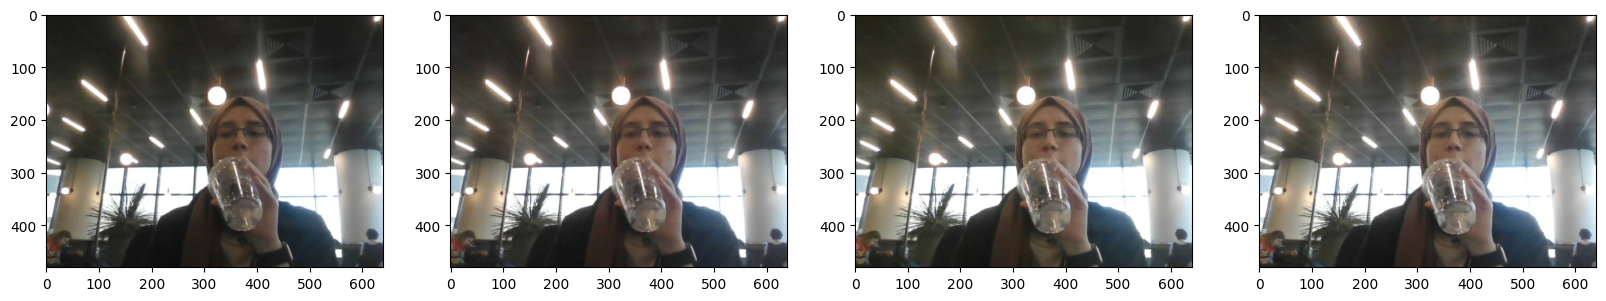

In [15]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()


Unaugmented manual data split
--14 assigned to val and test per file
--66 assigned to train

In [98]:
#
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)     


Image Augmentation

In [99]:
import albumentations as alb

In [100]:
augmentor = alb.Compose([alb.RandomCrop(width=450,height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                         bbox_params=alb.BboxParams(format='albumentations',label_fields=['class_labels']))

Test image and annotation

In [101]:
img = cv2.imread(os.path.join('data','train', 'images','9355573e-fbbc-11ed-99eb-b07d644bacb1.jpg'))


In [102]:
with open(os.path.join('data', 'train', 'labels', '9355573e-fbbc-11ed-99eb-b07d644bacb1.json'), 'r') as f:
    label = json.load(f)
label['shapes'][0]['points']

[[421.764705882353, 60.58823529411765],
 [502.3529411764706, 148.23529411764707]]

Extracting Coordinates and Rescaling

In [103]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]


In [104]:

coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.6590073529411765,
 0.12622549019607845,
 0.7849264705882353,
 0.3088235294117647]

In [105]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])


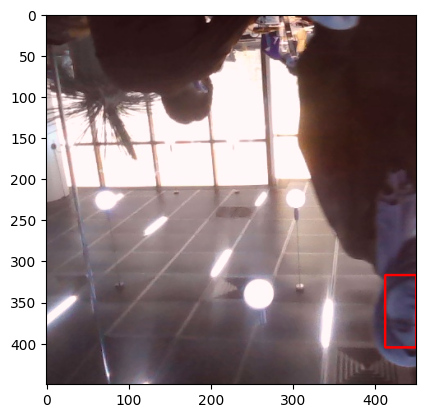

In [106]:
augmented['bboxes'][0][2:]
augmented['bboxes']
#augmented the face boxes and shifted to images to 
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

Augmentation Pipeline

In [108]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

[Errno 2] No such file or directory: 'aug_data\\train\\labels\\3e1cf06c-ef28-11ed-802f-b07d644bacb1.0.json'
[Errno 2] No such file or directory: 'aug_data\\train\\labels\\3e89e3b7-ef28-11ed-a91b-b07d644bacb1.0.json'
[Errno 2] No such file or directory: 'aug_data\\train\\labels\\3ef6aacd-ef28-11ed-8380-b07d644bacb1.0.json'
[Errno 2] No such file or directory: 'aug_data\\train\\labels\\3f636b51-ef28-11ed-88c0-b07d644bacb1.0.json'
[Errno 2] No such file or directory: 'aug_data\\train\\labels\\41169c32-ef28-11ed-ab1b-b07d644bacb1.0.json'
[Errno 2] No such file or directory: 'aug_data\\train\\labels\\4183a943-ef28-11ed-b0ed-b07d644bacb1.0.json'
[Errno 2] No such file or directory: 'aug_data\\train\\labels\\425d231d-ef28-11ed-b34d-b07d644bacb1.0.json'
[Errno 2] No such file or directory: 'aug_data\\train\\labels\\42c9d6cb-ef28-11ed-b1a4-b07d644bacb1.0.json'
[Errno 2] No such file or directory: 'aug_data\\train\\labels\\43373132-ef28-11ed-8e5c-b07d644bacb1.0.json'
[Errno 2] No such file or di

Load data to tensorflow
